In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [5]:
def loadImage(file_path, read_param):
    param_dict = {'gray': cv2.IMREAD_GRAYSCALE, 'color': cv2.IMREAD_COLOR}#, 'with_alpha': cv2.IMREAD_UNCHANGED}
    ret = cv2.imread(file_path, param_dict[read_param])
    
    if ret is None:
        print('check file path')
        return

    if read_param == 'color':
        ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB) 
        
    print('image', file_path, 'loaded')
    return ret

In [6]:
def plotImages(imgs, titles=[], gray=False, normalise=True, fig_size=(10,10), num_cols = 2):
    if isinstance(gray, bool):
        gray = [gray for i in imgs]
    
    if isinstance(normalise, bool):
        normalise = [normalise for i in imgs]
        
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    if not isinstance(titles, list):
        titles = [titles]
        
    num_rows = int(np.ceil(len(imgs)/num_cols))
    
    fig = plt.figure(fig_size)
    
    for i in len(imgs):
        ax = fig.add_subplot(num_rows, num_cols, i+1)
        
        img = imgs[i]
        vmin = 0
        vmax = 255
        if gray[i] and len(img.shape)==3: 
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        if normalised[i]:
            vmin = img.min()
            vmax = img.max()
        
        if gray[i]:
            ax.imshow(img, cmap='gray', vmin=vmin, vmax = vmax)
        else:
            ax.imshow(img, vmin=vmin, vmax=vmax)
        
        

In [7]:
def blurKernel(r, theta):
    kernel = np.zeros((r,r))
    kernel[r//2,:] = 1/r
    return rotateMatrix(kernel, theta)

In [8]:
def blurLegend(directions, magnitude):
    norm = mpl.colors.Normalize(0, np.pi)
    plt.imshow(norm(directions))
    plt.show()

In [9]:
def rotateMatrix(matrix, angle):
    from skimage.transform import rotate
    return rotate(matrix, angle)

In [10]:
def MSELoss(img1, img2):
    return np.sum(np.power(img1 - img2, 2))

In [11]:
def linearBlur(img, r, theta):
    kernel = blurKernel(r, theta)
    return cv2.filter2D(np.uint8(img), -1, kernel)

In [12]:
def nonUniformBlurKernels(img):
    """
    @param input: img (nxm)
    
    @return K: list of filters for each pixel
    """
    
    K = []
    for i in tqdm(range(img.shape[0])):
        for j in range(img.shape[1]):
            r = 1+min(2*(img.shape[0]-1-i)+1, 2*(img.shape[1]-1-j)+1, 20, 2*i+1, 2*j+1)
            if r%2==0:
                r-=1
                
            theta = 45 #np.random.randint(0,180)
            kernel = blurKernel(r,theta)

            K.append(kernel)
            
    return np.array(K)
            
def applyNonUniformBlur(img, K):
    """
    @param img: (nxm)
    @param K: list of kernels (nxm kernels)
    
    @return blurred_img
    """
    
    blurred_img = np.zeros(img.shape)
    n,m = img.shape
    
    for i in range(n):
        for j in range(m):
            kernel = K[i*m+j]
            k = kernel.shape[0]
            img_patch = img[i-k//2:i+k//2+1, j-k//2:j+k//2+1]
            blurred_img[i,j] = np.sum(img_patch*kernel)
            
    return blurred_img
    
def nonUniformBlur(img):
    """
    @param img: (nxm)
    
    @return blurred_img: (nxm)
    @return K: list of blur kernels (n*m)
    """
    
    K = nonUniformBlurKernels(img)
    blurred_img = applyNonUniformBlur(img, K)
    return blurred_img, K

image ./resources/building.jpg loaded


/envs/bluring/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


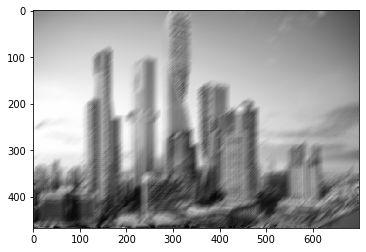

In [13]:
# img = loadImage('./resources/building.jpg', 'gray')
# np.set_printoptions(threshold=10000000000)

# blurred_img, K = nonUniformBlur(img)
# plt.imshow(blurred_img, cmap='gray')
# plt.figure()
# b2 = linearBlur(img, 5, 45)
# plt.imshow(b2, cmap='gray')
# plt.figure()
# plt.imshow(img, cmap='gray')
# plt.show()

In [11]:
def im2col(A, sz):
    m, n = A.shape
    s1, s2 = A.strides
    rows = m-sz[0]+1
    cols = n-sz[1]+1
    shp = sz[0],sz[1],rows,cols
    strd = s1,s2,s1,s2

    out = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out.reshape(sz[0]*sz[1],-1)[:,::1]